# Basic Example for generating samples from a GCM

A graphical causal model (GCM) describes the data generation process of the modeled variables. Therefore, after we fit
a GCM, we can also generate completely new samples from it and, thus, can see it as data generator for synthetic data based on the underlying
models. Generating new samples can generally be done by sorting the nodes in topological
order, randomly sample from root-nodes and then propagate the data through the graph by evaluating the downstream
causal mechanisms with randomly sampled noise. The ``dowhy.gcm`` package provides a simple helper function that does
this automatically and, by this, offers a simple API to draw samples from a GCM.

Lets take a look at the following example:

In [1]:
import numpy as np, pandas as pd

X = np.random.normal(loc=0, scale=1, size=1000)
Y = 2 * X + np.random.normal(loc=0, scale=1, size=1000)
Z = 3 * Y + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(data=dict(X=X, Y=Y, Z=Z))
data.head()

,X,Y,Z
0,0.458291,1.824751,5.958006
1,1.029321,3.801287,11.782274
2,-0.672589,0.877883,3.146077
3,-0.208438,-2.502232,-7.022653
4,0.121418,1.077939,1.652026


Similar as in the introduction, we generate data for the simple linear DAG X→Y→Z. Lets define the GCM and fit it to the
data:

In [2]:
import networkx as nx
import dowhy.gcm as gcm

causal_model = gcm.StructuralCausalModel(nx.DiGraph([('X', 'Y'), ('Y', 'Z')]))
gcm.auto.assign_causal_mechanisms(causal_model, data) # Automatically assigns additive noise models to non-root nodes
gcm.fit(causal_model, data)

Fitting causal models:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node X:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Y:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Z:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Z: 100%|██████████| 3/3 [00:00<00:00, 494.90it/s]

We now learned the generative models of the variables, based on the defined causal graph and the additive noise model assumption.
To generate new samples from this model, we can now simply call:

In [3]:
generated_data = gcm.draw_samples(causal_model, num_samples=1000)
generated_data.head()

,X,Y,Z
0,-1.334982,-2.671521,-8.256096
1,1.000761,2.439634,6.906319
2,-1.292595,-2.701322,-7.536053
3,-0.601800,-1.706713,-7.560390
4,0.078535,0.174521,1.147303


If our modeling assumptions are correct, the generated data should now resemble the observed data distribution, i.e. the generated samples correspond to the joint distribution we defined for our example data at the beginning. One way to make sure of this is to estimate the KL-divergence between observed and generated distribution. For this, we can make use of the evaluation module:

Test permutations of given graph:   0%|          | 0/6 [00:00<?, ?it/s]

Test permutations of given graph:  33%|███▎      | 2/6 [00:00<00:00, 12.25it/s]

Test permutations of given graph:  67%|██████▋   | 4/6 [00:00<00:00, 11.78it/s]

Test permutations of given graph: 100%|██████████| 6/6 [00:00<00:00, 17.63it/s]

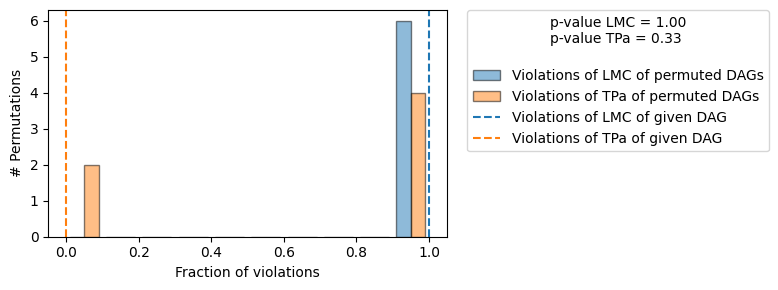

Evaluated and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Generated Distribution ====
The overall average KL divergence between the generated and observed distribution is 0.03176301791087766
The estimated KL divergence indicates an overall very good representation of the data distribution.

==== Evaluation of the Causal Graph Structure ====
+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is not informative because 2 / 6 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.33).                                                   |
| The given DAG viol

In [4]:
print(gcm.evaluate_causal_model(causal_model, data, evaluate_causal_mechanisms=False, evaluate_invertibility_assumptions=False))

This confirms that the generated distribution is close to the observed one. 

> While the evaluation provides us insights toward the causal graph structure as well, we cannot confirm the graph structure, only reject it if we find inconsistencies between the dependencies of the observed structure and what the graph represents. In our case, we do not reject the DAG, but there are other equivalent DAGs that would not be rejected as well. To see this, consider the example above - X→Y→Z and X←Y←Z would generate the same observational distribution (since they encode the same conditionals), but only X→Y→Z would generate the correct interventional distribution (e.g., when intervening on Y).